In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
from utils import WindowGenerator

In [3]:
dataframe = pd.read_csv("Google Finance.csv")
dataframe.head()

,Date,Close
0,02/01/2023 16:56:00,"14,3"
1,03/01/2023 16:56:00,"14,57"
2,04/01/2023 16:56:00,"14,97"
3,05/01/2023 16:56:00,"14,8"
4,06/01/2023 16:56:00,"14,55"


# Tratamento de Dados

## String para Decimal

Os valores numéricos estão representados como strings. É preciso convertê-los.

In [4]:
dataframe['Close'] = dataframe['Close'].str.replace(',', '.')
dataframe['Close'] = pd.to_numeric(dataframe['Close'])

## Visualizar dados

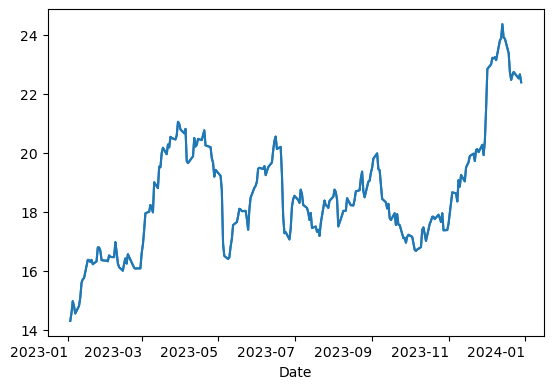

In [5]:
date_time = pd.to_datetime(dataframe.pop('Date'), format='%d/%m/%Y %H:%M:%S')

plot_features = dataframe['Close']
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = dataframe['Close'][:]
plot_features.index = date_time[:]
_ = plot_features.plot(subplots=True)

## Filtros

Os filtros a seguir não se aplicam ao projeto atual devido ao dataset utilizado, porém podem ser interessantes posteriormente.

In [6]:
# Filtrar colunas com mais de 90% de elementos nulos

# dataframe = dataframe[dataframe.columns[dataframe.isnull().mean() < 0.90]]

In [7]:
# Tratando NaN's

# dataframe = dataframe.interpolate()
# dataframe = dataframe.fillna(method='bfill')

# Tratamento para a Rede Neural

## Criando entradas e saídas de treino

As entradas são os 60 valores anteriores do preço da ação. A saída é o valor seguinte.

A seguir, também serão divididos os datasets de treino e de avaliação. Aprox. 70% dos dados serão
usados no treino, 20% na avaliação, e 10% no teste.

É importante notar também que a divisão foi feita seguindo a ordem dos dados no arquivo (os 70%
primeiros são para treino, os 20% seguintes para avaliação, e os 10% finais para teste).
Pode ser interessante mudar isso.

In [8]:
dataset = dataframe.iloc[:, 0].values

# Separação entre treino e avaliação

train_df = dataframe.iloc[0:int(dataset.shape[0] * 0.7), :]
val_df = dataframe.iloc[int(dataset.shape[0] * 0.7):int(dataset.shape[0] * 0.9), :]
test_df = dataframe.iloc[int(dataset.shape[0] * 0.9):, :]

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(173, 1)
(50, 1)
(25, 1)


In [9]:
# Normalização

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [10]:
# Variáveis para o modelo

''' IMPORTANTE!
O input_size não pode ser maior que o tamanho dos dataframes.
Bug anterior: val_df e test_df tinham menos elementos que
input_size!
'''

input_size = 20

In [11]:
w1 = WindowGenerator(input_width=input_size, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['Close'])

## Visualização

### Exemplo

Primeiro, foi criado um exemplo para visualização, contendo 3 exemplos de janela
a serem plotadas (example_window).

In [12]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[40:40+w1.total_window_size]),
                           np.array(train_df[80:80+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

# IMPORTANTE! O atributo example deve ser definido antes de usar o método plot

w1.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 21, 1)
Inputs shape: (3, 20, 1)
Labels shape: (3, 1, 1)


Então, foi criada a função plot, depois definida como método de WindowGenerator.

In [13]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

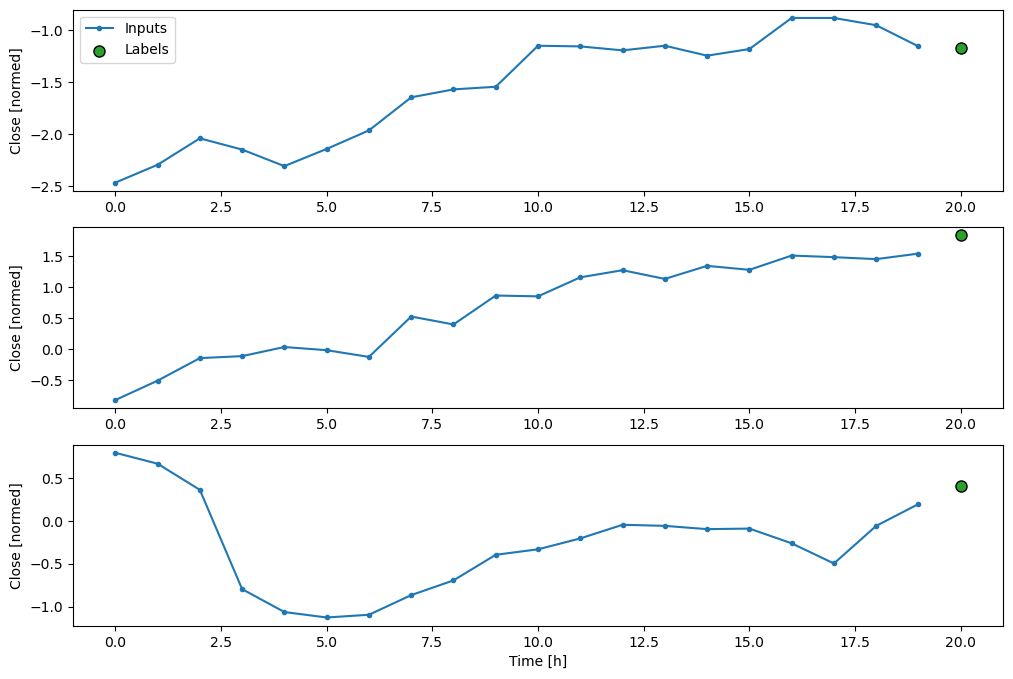

In [14]:
w1.plot()

# Baseline

Para comparação com modelos mais complicados.

A baseline desse caso será um modelo que retorna o valor atual como a previsão.

In [15]:
# Modelo

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]


# Single Step Window: a janela para o caso é de entrada única
    
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Close'])

example_window_baseline = tf.stack([np.array(train_df[0:2]),
                           np.array(train_df[40:42]),
                           np.array(train_df[80:82])])

single_step_window.example = single_step_window.split_window(example_window_baseline)

# Auxiliar: column_indices

column_indices = {name: i for i, name in enumerate(dataframe.columns)}




1/1 [==============================] - 0s 85ms/step - loss: 0.0895


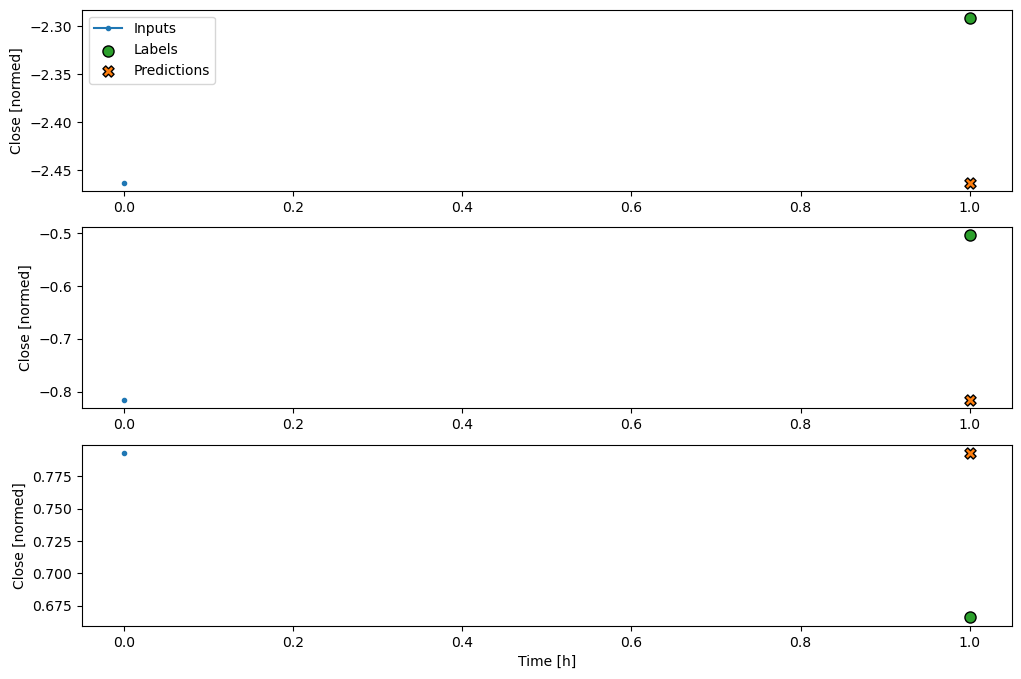

In [16]:
baseline = Baseline(label_index=column_indices['Close'])

baseline.compile(loss='mean_squared_error')

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test)

single_step_window.plot(baseline)

# Rede Neural

## RNN

#### IMPORTANTE:
Para a última camada LSTM, return_sequences deve ser definido conforme
foram definidas as labels da janela:

label_width=input_size => return_sequences=True

label_width=1 => return_sequences=False

#### IMPORTANTE 2:
Para a última camada Dense, units também deve ser definido conforme
foram definidas as labels da janela:

label_width=input_size => units=input_size

label_width=1 => units=1

#### IMPORTANTE 3:
Caso label_width=1, a última camada Reshape é necessária.

Caso contrário, deve-se retirá-la.

Esse passo é necessário para que o método plot funcione.

In [17]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=32, return_sequences=True))

model.add(tf.keras.layers.LSTM(units=32, return_sequences=False))

model.add(tf.keras.layers.Dense(units=1))

model.add(tf.keras.layers.Reshape(target_shape=(1, 1)))

model.compile(optimizer='adam', loss='mean_squared_error')

A próxima célula captura o output (longo) para a variável history

In [18]:
%%capture history
model.fit(w1.train, epochs=150)

In [26]:
# print(history)

Analisando o histórico (history), é possível avaliar se a rede estagnou após
um determinado número de epochs.

## Modelo 2

# Avaliando modelos

## RNN

In [22]:
performance['LSTM'] = model.evaluate(w1.test)

1/1 [==============================] - 1s 1s/step - loss: 0.4484


{'Baseline': 0.08946844190359116, 'LSTM': 0.44843873381614685}


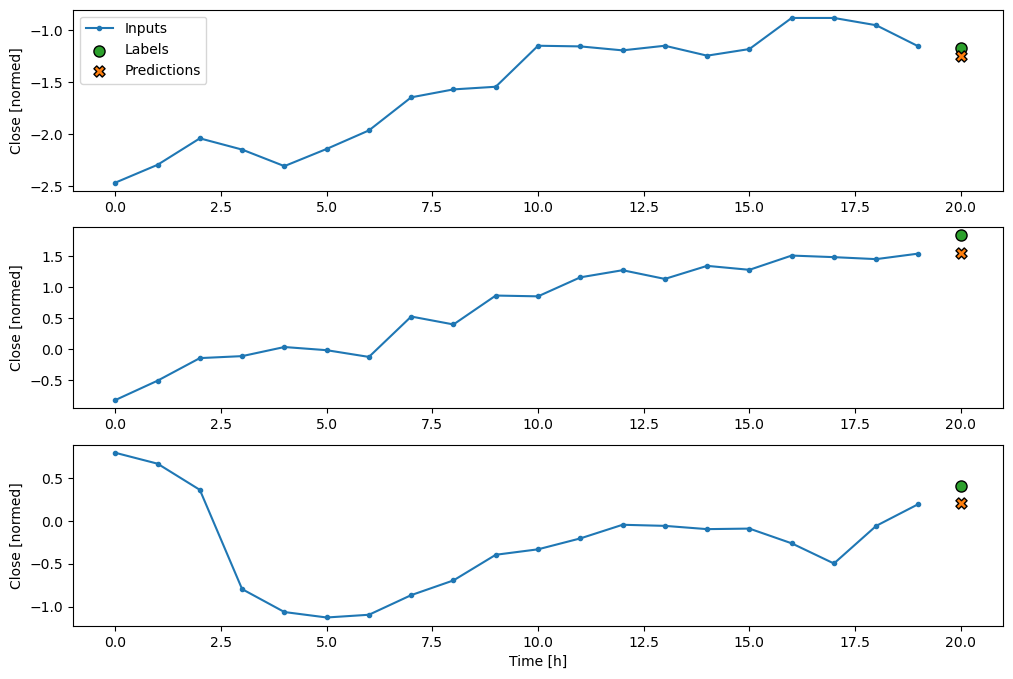

In [23]:
''' TODO: check if performance comparison is fair
(Different windows)
'''

print(performance)
w1.plot(model)

## Modelo 2

# Conclusões

...

TODOs:
- Considerar que existem dias faltantes na entrada
- Melhorar modelo